In [ ]:
!pip install opencv-contrib-python
!pip install imageio

In [ ]:
import numpy as np
from numpy import linalg as LA
import cv2
import math
import sys
import random
import matplotlib
from matplotlib import pyplot as plt
from operator import itemgetter
from multiprocessing import Pool
from tqdm import tqdm
import time

from PIL import Image, ImageDraw
from pathlib import Path
import imageio
from tqdm import tqdm

from functools import partial

import utils
import os


# bundle adjustment
import pysba as ba

# project files
import utils as h
import maths as mth
import matches as mt
import fundamental as fd
import track as tk
import vps as vp
import autocalibration as ac
import reconstruction as rc



DATA_PATH="Data_Lab5"

In [ ]:
with_intrinsics = True
NUM_IMAGES = 2  #Modify this number as you move along in the lab

Processing image 0 of sequence
  Image ../../Data_Lab5/0000_s.png loaded
  Colour image ../../Data_Lab5/0000_s.png loaded
  Features detected in image  0
    Found 2993 features 
  Vanishing points found
  Camera 0 set to identity
Processing image 1 of sequence
  Image ../../Data_Lab5/0001_s.png loaded
  Colour image ../../Data_Lab5/0001_s.png loaded
  Features detected in image  1
    Found 3000 features 
  Matching images 0 and 1 for obtaining tracks
  Correspondences matched between images 0 and 1
    Found 1019 matching correspondences
5000 187


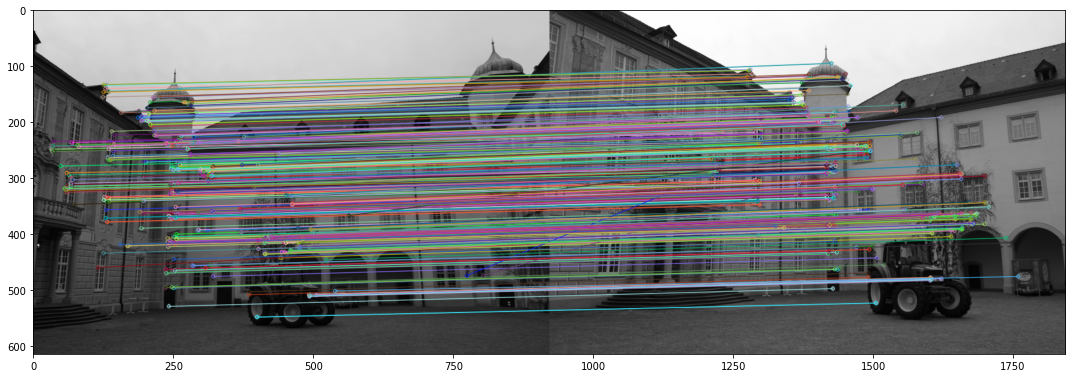

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:

imgs = []        # list of grayscale images
imgs_c = []      # list of colour images
feats = []       # list of features
matches = []     # list of dictionaries
tracks = []      # list of tracking views 
hs_vs = {}       # dictionary as hash table of views-tracks
vps = []         # list of vanishing points 
cams_pr = []     # list of projective cameras
cams_aff = []    # list of affine cameras
cams_euc = []    # list of euclidean cameras
Xprj = []         # list of projective 3d points
Xaff = []        # list of affine 3d points
Xeuc = []        # list of euclidean 3d points

# Get number of images to process
n = NUM_IMAGES
for i in range(0, n):
    if h.debug >= 0:
        print("Processing image", i, "of sequence")

    # read image
    imgs.append(h.read_image(i))
    imgs_c.append(h.read_image_colour(i))

    # find features
    feati = mt.find_features_orb(imgs[i], i)
    feats.append(feati)

    if i == 0:
        P0 = np.float32(np.c_[np.eye(3), np.zeros(3)])
        cams_pr.append(P0)
        vps.append(vp.estimate_vps(imgs[i]))
        if h.debug >= 0:
            print("  Camera 0 set to identity")
    else:
        for prev in range(0, i):  
            if h.debug >= 0:
                print("  Matching images", prev, "and", i, "for obtaining tracks")
            # match features
            m_ij = mt.match_features_hamming(feats[prev][1], feats[i][1], prev, i)

            # inliers
            x1 = []
            x2 = []

            for m in m_ij:
                x1.append([feats[prev][0][m.queryIdx].pt[0], feats[prev][0][m.queryIdx].pt[1], 1])
                x2.append([feats[i][0][m.trainIdx].pt[0], feats[i][0][m.trainIdx].pt[1], 1])
        
            x1 = np.asarray(x1)
            x2 = np.asarray(x2)
            
            # find fundamental matrix
            F, inliers = fd.compute_fundamental_robust(m_ij, x1, x2)

            if h.debug_display:
                img_ij = cv2.drawMatches(imgs[prev],feats[prev][0],\
                    imgs[i],feats[i][0],inliers,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
                plt.imshow(img_ij)
                fig = matplotlib.pyplot.gcf()
                fig.set_size_inches(18.5, 10.5)
                plt.show()

            if h.debug > 0:
                print("    Inliers: ", x1.shape[0])

            # refine matches and update the contents of matches
            x1 = x1[:, :2]
            x2 = x2[:, :2]
            xr1, xr2 = fd.refine_matches(x1, x2, F)
            tk.add_tracks(x1, x2, xr1.T, xr2.T, prev, i, tracks, hs_vs)
            #h.draw_matches_cv(imgs[prev], imgs[i], x1, x2)

            if h.debug >= 0:
                print("  Tracks added after matching", prev, "and", i)
            if h.debug > 0:
                print("    Size of tracks:", len(tracks))
                print("    Size of hash table of views:", len(hs_vs))

            if h.debug_display:
                h.display_epilines(imgs[prev], imgs[i], x1, x2, F)
                h.show_matches(imgs[prev], imgs[i], x1, x2)

        # compute projective cameras to use in projective reconstruction
        if i == 1:
            # TODO Compute the projective camera given F, according to
            # Result 9.15 of MVG (v = 0, lambda = 1).
            cams_pr.append(rc.compute_proj_camera(F, i))
        else:
            # OPTIONAL Compute resection as in MVG, Alg 7.1
            cams_pr.append(rc.resection(tracks, i))
            if h.debug >= 0:
                print("  Resection of camera", i, "performed")

        # projective triangulation for 3D structure
        Xprj = rc.estimate_3d_points_2(cams_pr[i-1], cams_pr[i], xr1, xr2)
        if h.debug >= 0:
            print('  Projective reconstruction estimated')

        # Add estimated 3d projective points to tracks
        tk.add_pts_tracks(Xprj, x1, x2, i-1, i, tracks, hs_vs)
        if h.debug >= 0:
            print('  Projective 3D points added to tracks')

        # TODO compute projective reprojection error
        error_prj = rc.compute_reproj_error(Xprj, cams_pr[i-1], cams_pr[i], xr1, xr2)
        if h.debug > 0:
            print("    Projective reprojection error:", error_prj)

        if h.debug_display:
            h.display_3d_points(Xprj.T[:, :3], x1, imgs_c[i])
        
        # Affine rectification
        vps.append(vp.estimate_vps(imgs[i]))
        # TODO Estimate homography that makes an affine rectification
        # With the vanishing points, the plane at the infinity is computed. 
        # Then the affine homography is built with the coordinates of the infinity plane
        aff_hom = ac.estimate_aff_hom([cams_pr[i-1], cams_pr[i]], [vps[i-1], vps[i]])

        # TODO Transform 3D points and cameras to affine space
        Xaff, cams_aff = rc.transform(aff_hom, Xprj, cams_pr)

        # Add estimated 3d affine points to tracks (reuse your code)
        tk.add_pts_tracks(Xaff, x1, x2, i-1, i, tracks, hs_vs)
        if h.debug >= 0:
            print('  Affine 3D points added to tracks')
        
        # TODO compute affine reprojection error (reuse your code)
        error_aff = rc.compute_reproj_error(Xaff, cams_aff[i-1], cams_aff[i], xr1, xr2)
        if h.debug > 0:
            print("    Affine reprojection error:", error_aff)

        if h.debug_display:
            h.display_3d_points(Xaff.T[:, :3], x1, imgs_c[i])

        # Metric rectification
        # TODO Perform Metric rectification. First compute the transforming
        # homography from vanishing points and the camera constrains skew = 0,
        # squared pixels. Then perform the transformation to Euclidean space
        # (reuse your code)
        if i == 1 and with_intrinsics:
            cams_euc = rc.compute_eucl_cam(F, x1, x2)
            Xeuc = rc.estimate_3d_points_2(cams_euc[0], cams_euc[1], xr1, xr2)
        else: # compare results with the results from intrinsic camera
            euc_hom = ac.estimate_euc_hom(cams_aff[i], vps[i])
            Xeuc, cams_euc = rc.transform(euc_hom, Xaff, cams_aff)

        # TODO Add estimated 3d euclidean points to tracks (reuse your code)
        tk.add_pts_tracks(Xeuc, x1, x2, i-1, i, tracks, hs_vs)
        if h.debug >= 0:
            print('  Euclidean 3D points added to tracks')
        
        # TODO compute metric reprojection error (reuse your code)
        error_euc = rc.compute_reproj_error(Xeuc, cams_euc[i-1], cams_euc[i], xr1, xr2)
        if h.debug > 0:
            print("    Euclidean reprojection error:", error_euc)

        if h.debug_display:
            h.display_3d_points(Xeuc.T[:, :3], x1, imgs_c[i])

        # Bundle Adjustment
        # TODO Adapt cameras and 3D points to PySBA format
        cams_ba, X_ba, x_ba, cam_idxs, x_idxs = ba.adapt_format_pysba(tracks, cams_euc)

        badj = ba.PySBA(cams_ba, X_ba, x_ba, cam_idxs, x_idxs)
        cams_ba, Xba = badj.bundleAdjust()
        # Update 3D points and tracks with optimised cameras and points
        tk.update_ba_pts_tracks(Xba, x1, x2, i-1, i, tracks, hs_vs)
        if h.debug >= 0:
            print("  Bundle Adjustment performed over", i, "images")

        # render results
        #if h.debug_display:
        h.display_3d_points_2(Xba)

if h.debug >= 0:
    print("Structure from Motion applied on sequence of", n, "images")

